### Imports

In [15]:
import os
import random
import csv

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.metrics import confusion_matrix,\
    precision_score, ConfusionMatrixDisplay,\
        recall_score, precision_recall_curve, f1_score

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

import config
from utils import load_csv, get_predictions,\
    draw_predicted_bboxes, IOU_metric,\
        compute_precision_recall, plot_pr_curve

%matplotlib inline

### Test Model

In [ ]:
MODEL_PATH = os.path.sep.join([config.BASE_OUTPUT, "VGG_detector.h5"])

In [3]:
# LOAD model
print("[INFO] loading object detector...")
model = load_model(config.MODEL_PATH)

[INFO] loading object detector...
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-08 10:02:53.577210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 10:02:53.577233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
valid_rows = load_csv(config.VALID_CSV_PATH)
imagePaths=[]

for row in valid_rows:
    img_path = os.path.join(config.VALID_IMAGES_PATH, row[0])
    imagePaths.append(img_path)

In [5]:
# Get predictions and draw bounding boxes
predictions_list = get_predictions(model, imagePaths)
image_list = draw_predicted_bboxes(predictions_list)

2023-03-08 10:02:59.556612: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-08 10:02:59.636372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


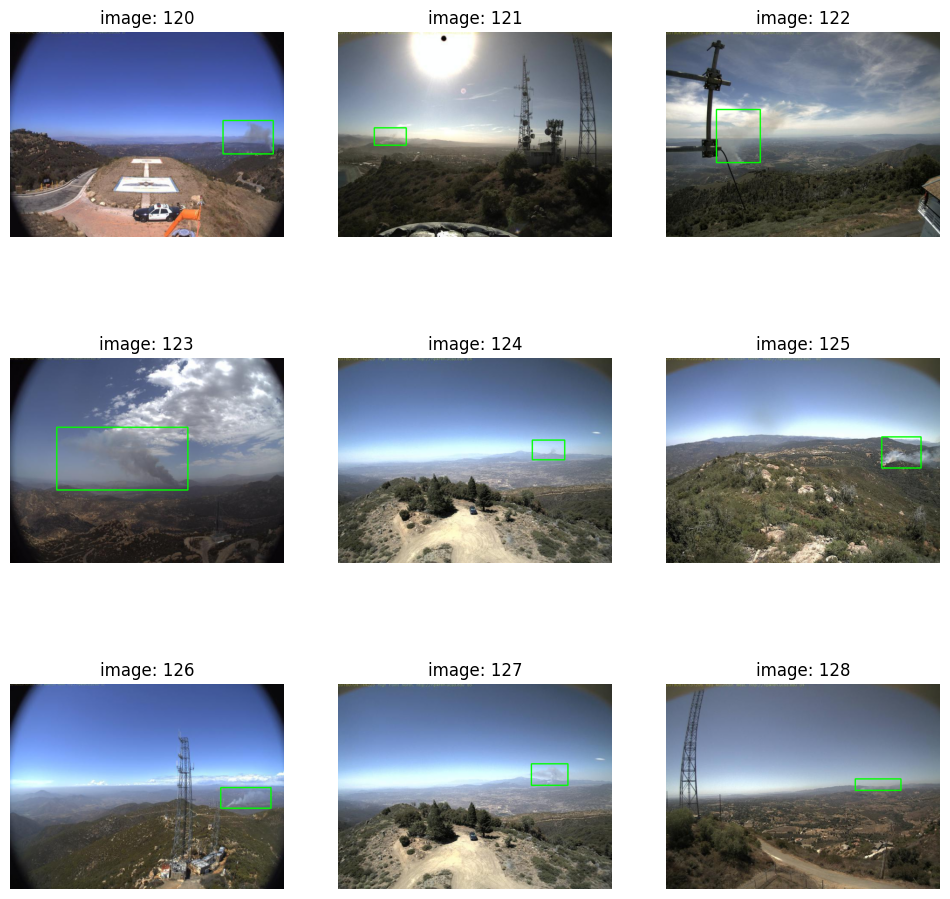

In [30]:
floor = random.randint(0,len(image_list)-9)
plt.figure(figsize=(12, 12))

for i, image in enumerate(image_list[floor:floor+9]):
        ax = plt.subplot(3, 3, i + 1)
        plt.title(f"image: {floor+i}")
        plt.imshow(image)
        plt.axis("off")

In [45]:
# WRITE predictions to csv
csv_out = os.path.sep.join([config.BASE_OUTPUT, 'VGG_predictions_list.csv'])
csv_header = ['filename', 'xmin', 'ymin', 'xmax', 'ymax']  
with open(csv_out, 'w') as f:
    write = csv.writer(f)
    write.writerow(csv_header)
    write.writerows(predictions_list) 

___

### Metrics

#### - Data load and processing

In [2]:
csv_out = os.path.sep.join([config.BASE_OUTPUT, 'VGG_predictions_list.csv'])
predictions_columns=['filename', 'pred_xmin', 'pred_ymin', 'pred_xmax', 'pred_ymax']
valid_columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

df_preds = pd.read_csv(csv_out, header=0,
                       names=predictions_columns)

df_valid = pd.read_csv(config.VALID_CSV_PATH, header=0,
                       names=valid_columns)

In [3]:
# NORMALIZE validation bounding boxes values
df_valid['val_xmin']=df_valid['xmin']/df_valid['width']
df_valid['val_xmax']=df_valid['xmax']/df_valid['width']
df_valid['val_ymin']=df_valid['ymin']/df_valid['height']
df_valid['val_ymax']=df_valid['ymax']/df_valid['height']

In [4]:
# Convert file path to file name
def return_filename(file_path):
    """Get filename as a string."""
    return file_path.astype(str).get(0).split('/')[-1]

df_preds['filename']=df_preds[['filename']].apply(return_filename, axis=1)

# Get only filename and scaled predictions
# for the validation df
df_valid=df_valid.drop(['width', 'height', 'xmin',
                        'ymin', 'xmax', 'ymax'], axis=1)

In [5]:
# Join df's
eval_df = pd.merge(df_preds, df_valid, on=['filename'])
eval_df=eval_df.rename(columns={"class":"true_class"})

In [6]:
# x1, y1, w1, h1 = box1
eval_df['valid_box']=eval_df[['val_xmin','val_ymin',
                              'val_xmax', 'val_ymax']].values.tolist()

eval_df['pred_box']=eval_df[['pred_xmin','pred_ymin',
                             'pred_xmax', 'pred_ymax']].values.tolist()

eval_df=eval_df.drop(['pred_xmin','pred_ymin','pred_xmax','pred_ymax',
                      'val_xmin','val_xmax','val_ymin','val_ymax'], axis=1)
eval_df

,filename,true_class,valid_box,pred_box
0,ck0k9aqm99o2o0721aml8qpqr_jpeg.rf.028c79a871f1...,smoke,"[0.61875, 0.4395833333333333, 0.7703125, 0.50625]","[0.605515, 0.44345564, 0.7071584, 0.5125798]"
1,ck0ndrnhi3fkn0794vbn53c08_jpeg.rf.00da459deaa7...,smoke,"[0.3046875, 0.4270833333333333, 0.3328125, 0.4...","[0.28562003, 0.41354436, 0.3228954, 0.4709998]"
2,ck0ncvnd332hj079400vhocib_jpeg.rf.01edcd18890b...,smoke,"[0.0015625, 0.3541666666666667, 0.25, 0.677083...","[0.015582321, 0.25885633, 0.24745934, 0.6757925]"
3,ck0ovrdff7ir20848kelskyn8_jpeg.rf.1424f9ef8aad...,smoke,"[0.4875, 0.2375, 0.875, 0.5395833333333333]","[0.4418335, 0.25484547, 0.8107296, 0.52012444]"
4,ck0tx0999u6br0944s68atde0_jpeg.rf.0e5c93b75738...,smoke,"[0.371875, 0.5333333333333333, 0.821875, 0.65625]","[0.46806613, 0.53774565, 0.807501, 0.65390867]"
...,...,...,...,...
142,ck0na8r4s7dor0721s8pn4uvo_jpeg.rf.efcbec0a9d48...,smoke,"[0.6984375, 0.4708333333333333, 0.9203125, 0.5...","[0.6850161, 0.46623355, 0.85075575, 0.52596414]"
143,ck0rr6kut5kx30838ethvdv5u_jpeg.rf.ffc29757cca1...,smoke,"[0.7, 0.4708333333333333, 0.85625, 0.525]","[0.6851634, 0.46622396, 0.85133255, 0.52228147]"
144,ck0qdeht7feba0794xskx01vd_jpeg.rf.d9915a67ae11...,smoke,"[0.484375, 0.3125, 0.834375, 0.5270833333333333]","[0.48224494, 0.29757786, 0.8151006, 0.519569]"
145,ck0txxd8f6p0l08484tupben9_jpeg.rf.d0f6adf1317f...,smoke,"[0.50625, 0.43333333333333335, 0.6546875, 0.52...","[0.49842426, 0.41747928, 0.6610261, 0.52897114]"


#### - IUO

In [7]:
# Intersection Over Union
eval_df['IUO']=eval_df.apply(lambda x: IOU_metric(x.pred_box, x.valid_box), axis=1)

In [8]:
greater = (eval_df[['IUO']] > 0.8 ).value_counts().values
#less = (eval_df[['IUO']] < 0.8).value_counts().values
print(f"IUO mean is: {eval_df['IUO'].mean():.4f}")
print(f"Minimum IUO is: {eval_df['IUO'].min():.2f}")
print(f"Maximum IUO is: {eval_df['IUO'].max():.2f}")
print(f"IOU is greater than 0.8 in {greater[0] / len(eval_df):.0%} of the cases")
print(f"IOU is less than 0.8 in {greater[1] / len(eval_df):.0%} of the cases")

IUO mean is: 0.8463
Minimum IUO is: 0.53
Maximum IUO is: 0.99
IOU is greater than 0.8 in 72% of the cases
IOU is less than 0.8 in 28% of the cases


#### - Precission, recall

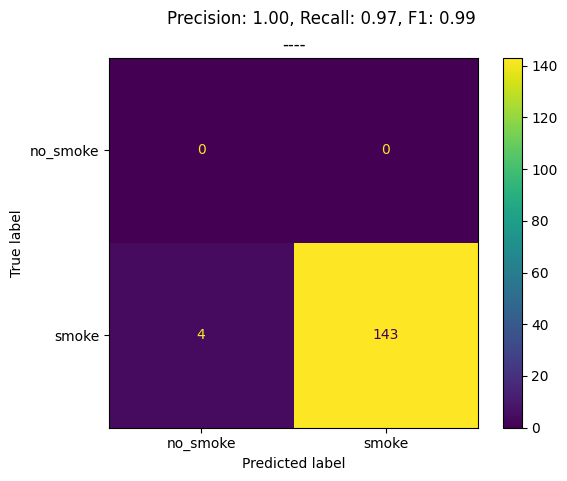

In [17]:
# IUO > 0.6 labeled as 'smoke', otherwise 'no_smoke'
eval_df['pred_class']=eval_df['IUO'].apply(lambda x: 'smoke' if x >= 0.6 else 'no_smoke')

y_pred=eval_df['pred_class'].values.tolist()
y_true=eval_df['true_class'].values.tolist()
y_iuo=eval_df['IUO'].values.tolist()

TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

precision = precision_score(y_true, y_pred, pos_label="smoke")
recall = recall_score(y_true, y_pred, pos_label="smoke")
f1 = f1_score(y_true, y_pred, pos_label="smoke", average='binary')

conf = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.suptitle(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
plt.title(f'----')
plt.show(conf)


In [13]:
thresholds = np.arange(start=0.1, stop=0.9, step=0.05)
precisions, recalls = compute_precision_recall(
    y_true=y_true, pred_scores=y_iuo,
    thresholds=thresholds)

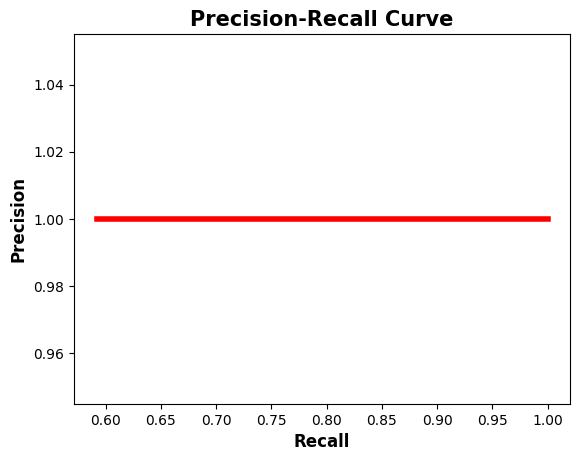

In [14]:
plot_pr_curve(precisions, recalls)